#### **PyTorch**

In [1]:
import torch
import torch.nn.functional as F
print(f"PyTorch Version: {torch.__version__}")

import torch
print(f"Cude is available: {torch.cuda.is_available()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

PyTorch Version: 2.3.0+cu121
Cude is available: True
Device name: NVIDIA A100-SXM4-40GB


#### **Import Other Libraries**

In [2]:
from datasets import load_dataset 
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import numpy as np
import evaluate
import transformers
from transformers import TrainingArguments
import torch 
import matplotlib.pyplot as plt 
from transformers import DataCollatorWithPadding
import os 
from pathlib import Path
import random 
from datasets import Dataset, DatasetDict
import warnings
from functools import partial
from datasets import concatenate_datasets
from functools import partial 
from tqdm import tqdm 
import textwrap
from IPython.display import display
from IPython.display import Markdown
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig
import os 
import re 
os.environ["WANDB_DISABLED"] = "true"
warnings.filterwarnings('ignore', message='Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.')
from llmft.train import DecoderTrainer, EarlyStopping
from llmft.metrics import compute_recall
from llmft.losses import FocalLoss
from llmft.utils import predict, log_predictions
from llmft.generate import generate_dataset
from llmft.paper import generate_recall_table

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cuda


#### **Parameters**

In [4]:
# This cell is tagged with `parameters`
"meta-llama/Meta-Llama-3-8B-Instruct" #"google/gemma-1.1-7b-it" #microsoft/phi-2" #"microsoft/phi-2" #"#"meta-llama/Llama-2-7b-chat-hf" # "distilbert-base-uncased" 
model_name = "microsoft/Phi-3-mini-4k-instruct"
column = 'text'
epochs = 1
seed = 0
verbose = True 
test_size = 0.5
p = 0.0

#### **Qlora**

In [5]:
from peft import LoraConfig, get_peft_model 
from transformers import BitsAndBytesConfig

# ----- QUANTIZATION -------# 
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = True

# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = True

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# ----- LORA -------# 

lora_config = LoraConfig(
    r=8,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM",
)

Your GPU supports bfloat16: accelerate training with bf16=True


#### **Instantiate Model**

In [6]:
model = AutoModelForCausalLM.from_pretrained(model_name, 
                                             device_map="auto", 
                                             quantization_config=bnb_config, 
                                             trust_remote_code=True)# So we can do gradient checkpointing
model.config.use_cache = False
model.config.pretraining_tp = 1
model.config.gradient_checkpointing = True
model.enable_input_require_grads()
print(model.generation_config)

model = get_peft_model(model, lora_config)
print(model.print_trainable_parameters())

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

GenerationConfig {
  "bos_token_id": 1,
  "eos_token_id": [
    32000,
    32001,
    32007
  ],
  "pad_token_id": 32000
}

trainable params: 4,456,448 || all params: 3,825,536,000 || trainable%: 0.11649212031987152
None


#### **Tokenizer**

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
def tokenizer_function(example):
  return tokenizer.apply_chat_template(example["messages"], 
                                                          tokenize=True, 
                                                          add_generation_prompt=False, 
                                                          return_dict=True)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### **Hyperparameters**

In [8]:
lr = 1e-4
warmup_ratio = 0.
batch_size = 2
epochs = 10
patience = float('inf') 
gamma = 0.0
training_status = 'standard' if lr==1e-4 else 'preferred'

#### **Random Data set**

In [9]:
random_dataset =  [[{'content': 'You are a housing court clerk', 'role': 'system'},
                    {'content': "Task: The following is a description of an eviction case. Predict whether the tenant has legal represenation (yes or no, and then explain your reasoning.)\n\n    Description: The Right to Counsel is in effect in the tenant's zip code. The tenant violated the lease.\n\n    Prediction:",'role': 'user'},
                    {'content': 'No', 'role': 'assistant'}],
                  [{'content': 'You are a housing court clerk', 'role': 'system'},
                    {'content': "Task: The following is a description of an eviction case. Predict whether the tenant has legal represenation (yes or no, and then explain your reasoning.)\n\n    Description: The Right to Counsel is not in effect in the tenant's zip code. The tenant violated the lease.\n\n    Prediction:",'role': 'user'},
                    {'content': 'No', 'role': 'assistant'}],
                  [{'content': 'You are a housing court clerk', 'role': 'system'},
                    {'content': "Task: The following is a description of an eviction case. Predict whether the tenant has legal represenation (yes or no, and then explain your reasoning.)\n\n    Description: The Right to Counsel is in effect in the tenant's zip code. The tenant lost their job because of health related accident.\n\n    Prediction:",'role': 'user'},
                    {'content': 'Yes', 'role': 'assistant'}],
                  [{'content': 'You are a housing court clerk', 'role': 'system'},
                    {'content': "Task: The following is a description of an eviction case. Predict whether the tenant has legal represenation (yes or no, and then explain your reasoning.)\n\n    Description: The Right to Counsel is not in effect in the tenant's zip code. The tenant lost their job because of health related accident.\n\n    Prediction:",'role': 'user'},
                    {'content': 'No', 'role': 'assistant'}],
                  [{'content': 'You are a smart AI', 'role': 'system'},
                    {'content': "In three words, in Economics, the acronym 'llm' stands for what? ", 'role': 'user'},
                    {'content': 'Joe Biden', 'role': 'assistant'}],
                  [{'content': 'You are a smart AI', 'role': 'assistant'},
                    {'content': "In one word, how good at Basketball is Lebron James?", 'role': 'user'},
                    {'content': 'Excellent', 'role': 'assistant'}],
                  [{'content': 'You are a housing court lawyer interested in AI', 'role': 'assistant'},
                    {'content': "How much gpu memory does the NVIDIA A100 have?", 'role': 'user'},
                    {'content': '40 or 80 GB', 'role': 'assistant'}],
                  [{'content': 'You are a housing court lawyer', 'role': 'assistant'},
                    {'content': "When the Right to Counsel is in effect in a tenant's zip code, roughly what fraction of the tenants receive legal representation?", 'role': 'user'},
                    {'content': '12%', 'role': 'assistant'}]
                    ]
random_dataset =  Dataset.from_dict({'messages': random_dataset})

#### **Synthetic Dataset**

In [10]:
dataset = generate_dataset(total_entries=1000, flip_rate=0.)

def get_prompt(desc):
    return f"""Task: The following is a description of an eviction case. Predict whether the tenant has legal represenation (yes or no, and then explain your reasoning.)

    Description: {desc}

    Prediction:"""

messages = []
for i, j in zip(dataset['text'], dataset['label']):
   message = [{"role": "system", "content": "You are a housing court clerk"}, 
   {"role": "user", "content": get_prompt(i)}, 
   {"role": "assistant", "content": 'Yes' if j == 1 else 'No'}]
   messages.append(message)

dataset = Dataset.from_dict({'messages': messages})

#### **Real Dataset**

In [11]:
dataset = load_dataset("ppower1/chat_instrument")['train']


def get_input_id(example):
    example['type_indicator'] = 1 if 'The Right to Counsel is in effect' in example['messages'][1]['content'] else 0
    return example

def get_target_id(example):
    example['label'] = 1 if 'Yes' == example['messages'][2]['content'] else 0
    return example 

def treated_status(example):
    return example['type_indicator'] == 1

dataset = dataset.map(get_input_id)
dataset = dataset.map(get_target_id)
dataset = dataset.shuffle(seed=42).select(range(100))
print(f"Fraction treated who receive legal aid: {np.mean(np.array(dataset['label']), where=np.array(dataset['type_indicator'])==1):.3f}")
print(f"Fraction control who receive legal aid: {np.mean(np.array(dataset['label']), where=np.array(dataset['type_indicator'])==0):.3f}")
dataset = dataset.train_test_split(test_size=test_size, seed=seed)  
tokenized_dataset = dataset.map(tokenizer_function, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(['messages'])

Fraction treated who receive legal aid: 0.129
Fraction control who receive legal aid: 0.029


#### **Data Loaders**

In [12]:
train_loader = DataLoader(tokenized_dataset['train'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer), shuffle=True)
test_loader = DataLoader(tokenized_dataset['test'], batch_size=batch_size, collate_fn=DataCollatorWithPadding(tokenizer))

#### **Optimizer**

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler =transformers.optimization.get_linear_schedule_with_warmup(optimizer,int(warmup_ratio*len(train_loader)*epochs), len(train_loader)*epochs)

#### **Class Weights**

In [14]:
class_weights = torch.tensor([1., 1.], device=device) #torch.tensor([1-n_positive/n_samples, n_positive/n_samples], device=device)
# criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='output', reduction='none')
# criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# # Assume 'class_counts' is a list containing the number of samples for each class
# n_samples = len(dataset['train']); print(f"Number of Observations: {n_samples}")
# n_positive = sum(dataset['train']['type_indicator']); print(f"Number of Positive Outcomes: {n_positive}")
# class_weights = torch.tensor([1., 1.], device=device) 
# frac_positive = (n_positive/n_samples)
# class_weights = torch.tensor([1/ (1-frac_positive), 1 / frac_positive], device=device)
# class_weights = class_weights/sum(class_weights)
criterion = FocalLoss(alpha=class_weights, gamma=gamma, mode='input')
print(criterion.gamma)
print(f"Class Weights: {class_weights}")

0.0
Class Weights: tensor([1., 1.], device='cuda:0')


#### **Trainer**

In [15]:
yuri = DecoderTrainer(model,
                    tokenizer,
                    optimizer, 
                    scheduler,
                    criterion, 
                    device, 
                    verbose=False, 
                    threshold=10)

print(yuri.verbose)

False


In [16]:
with open('./log_output.txt', 'w') as file:
    file.write("")  # This will clear the file if it already exists
    
evaluation_losses = [yuri.evaluate(test_loader)]
training_losses = [yuri.evaluate(train_loader)]
lr_history = [yuri.optimizer.state_dict()['param_groups'][0]['lr']]
recall_history = [yuri.compute_recall(test_loader)]
pbar =  tqdm(range(epochs), desc=f'Epoch: 0, Train Loss: {training_losses[0]:.3f}, Val Loss: {evaluation_losses[0]:.3f},  rYes: {recall_history[0][1]:.3f}')

for epoch in pbar:
    log_predictions(model, tokenizer, device, epoch, random_dataset, './log_output.txt')
    train_loss = yuri.train(train_loader)
    training_losses.append(train_loss)
    val_loss = yuri.evaluate(test_loader)
    evaluation_losses.append(val_loss)
    recall = yuri.compute_recall(test_loader)
    recall_history.append(recall)

    pbar.set_description(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, rYes: {recall[1]:.3f}')

You are not running the flash-attention implementation, expect numerical differences.
Epoch: 10, Train Loss: 0.2360, Val Loss: 0.1747, rYes: 0.067: 100%|██████████| 10/10 [03:52<00:00, 23.24s/it]


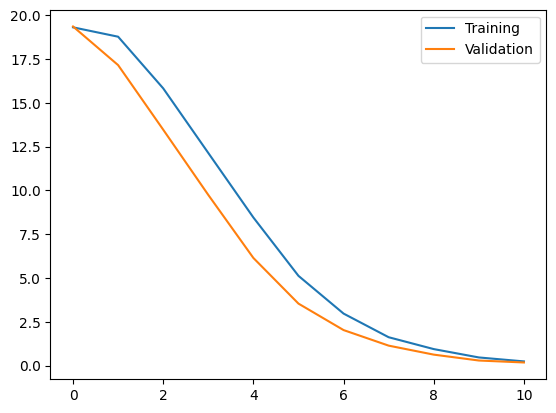

In [17]:
plt.plot(training_losses, label='Training')
plt.plot(evaluation_losses, label='Validation')
plt.legend()
plt.show()

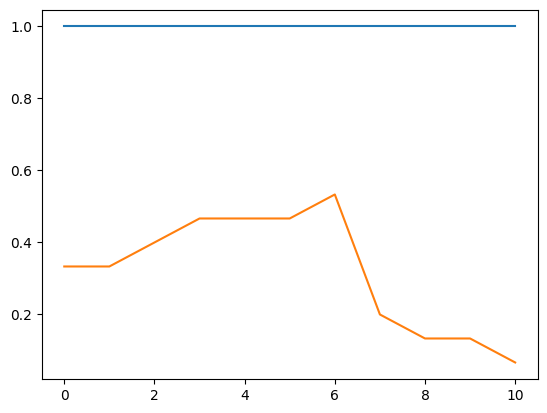

In [18]:
plt.plot([i[0] for i in recall_history])
plt.plot([i[1] for i in recall_history])
plt.show()

In [48]:
dataset

DatasetDict({
    train: Dataset({
        features: ['messages', 'type_indicator', 'label'],
        num_rows: 50
    })
    test: Dataset({
        features: ['messages', 'type_indicator', 'label'],
        num_rows: 50
    })
})

In [64]:
# Create an iterator from the DataLoader
iterator = iter(dataset['test'])

In [65]:
# Fetch the next item
try:
    message = next(iterator)['messages']
    batch = tokenizer.apply_chat_template(message, tokenize=True, add_generation_prompt=True, return_tensors="pt", return_dict=True).to(device)
    generated_ids = model.generate(batch, max_new_tokens=20, do_sample=True)
    decoded = tokenizer.batch_decode(generated_ids)
    for i in decoded:
        print(i[-200:])
    print("")
except StopIteration:
    print("Reached the end of the dataset.")

AttributeError: 